# Predicting Hospital Length of Stay of General Surgical Patients

### Part 2

In [1]:
#Import libraries

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split  
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score, confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier

from scipy.stats import chi2_contingency  
from scipy.stats import norm

## Baseline Models

In [2]:
#importing csv 
df2=pd.read_csv("data_cleaned.csv")

In [3]:
#Function to prepare X encoding categorical variables

def prepare_X(X):
    X=pd.get_dummies(X, columns=X.select_dtypes(include='object').columns, drop_first=True)   #first category to be dropped during the encoding process to avoid multicollinearity and reduce the dimensionality of the encoded data.
    return X

In [4]:
# Function to prepare target y encoding Target "LOS" column

def prepare_y(y):
    encoder = OrdinalEncoder(categories=[['short', 'medium', 'prolonged']])
    ordinal_data = encoder.fit_transform(y)
    return pd.DataFrame(ordinal_data, columns=['LOS'])

In [5]:
X = prepare_X(df2.drop(["LOS", "LOS_days"], axis=1))
y = prepare_y(pd.DataFrame(df2["LOS"]))

In [6]:
models = [
    RandomForestClassifier(),
    XGBClassifier(objective="multi:softmax"),  #multi:softmax because of the multiclass target
    LogisticRegression(multi_class='multinomial'),
    KNeighborsClassifier(),
    SVC()
]

def different_models(models, X, y):
    results = []  # List to store the results from each model
    
    # X-y split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) # stratify=y ensures stratified split, maintaining the class distribution (short, medium and prolonged) in both y_train and y_test.

    
    for model in models:
        model.fit(X_train, y_train)  # Training the model
        predictions = model.predict(X_test)  # Predicting on X_test for validation
        
        # Metrics: 
        accuracy = accuracy_score(y_test, predictions)
        precision = precision_score(y_test,predictions, average='macro')
        recall = recall_score(y_test,predictions, average='macro')
        f1 = f1_score(y_test, predictions, average='macro')
        #conf_matrix=confusion_matrix(y_test, predictions)
        #plot_cm = plot_confusion_matrix(model, X_test, y_test)
        #classreport = classification_report(y_test, predictions)
        
        results.append({'model': model.__class__.__name__, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1})
            
    #Plotting accuracy scores for comparison between models
    model_names = [result['model'] for result in results]
    accuracies = [result['accuracy'] for result in results]
    plt.figure(figsize=(8, 3))
    plt.barh(model_names, accuracies, color=('navy'),  height=0.8)
    plt.xlabel('Accuracy')
    plt.ylabel('Models')
    plt.title(' Comparing Accuracy Scores')
    
    
    for index, score in enumerate(accuracies):
        plt.text(score, index, f'{score:.2f}')

    plt.show()
    
    #return results

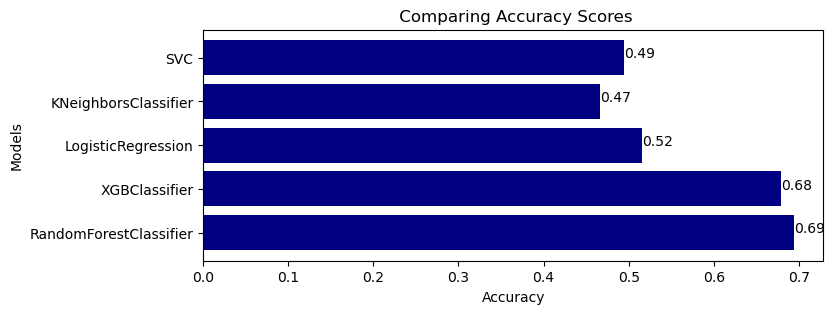

In [7]:
different_models(models, X, y)

**RF Classifier** and **XGB** seems to be the most promising models in predicting the multiclass target - Length of Stay (LOS).
Let's perform some refinements in our dataset and see if we can improve the accuracy score.

## Models Refinement

### Class Imbalance

In [8]:
df2.LOS.value_counts()

# prolonged and medium are the minority classes, if we don't balance target, models might be biased towards the majority classes.

short        1883
prolonged    1783
medium       1004
Name: LOS, dtype: int64

#### SMOTE - Synthetic Minority Over-sampling Technique

In [9]:
# Function to create synthetic examples on the minority classes, in this case "prolonged" and "medium"

def upsampling_smote(X, y):
    smote = SMOTE()
    X, y = smote.fit_resample(X, y)
    return X, y

In [10]:
#Preparing X and y 

X = prepare_X(df2.drop(["LOS", "LOS_days"], axis=1))
y = prepare_y(pd.DataFrame(df2["LOS"]))

#Upsampling 

X, y = upsampling_smote(X, y)

y_df=pd.DataFrame(y)
y_df.value_counts() # classes are balanced

LOS
0.0    1883
1.0    1883
2.0    1883
dtype: int64

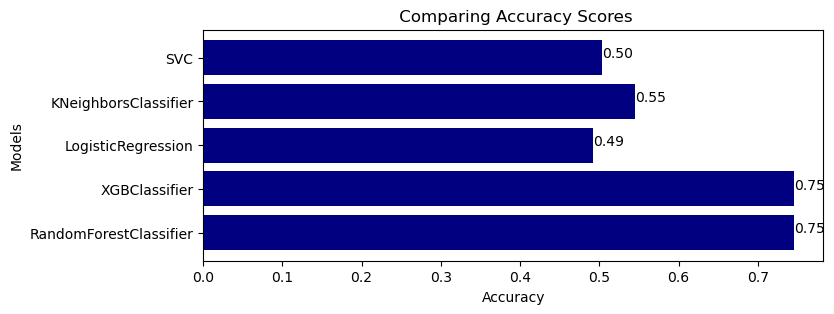

In [11]:
different_models(models, X, y)

#### Accuracy of KNN, RandomForestClassifier and XGBClassifier improved with balancing target "LOS",  perhaps by making them more robust and less prone to overfitting.

### Data Scaling


Random Forest Classifier and Extreme Gradient Boosting don't require data to be scaled because it does not depend on the distribution of the features, however scaling can be beneficial to LogisticRegression, KNN and SVC for better performances. 


In [12]:
categorical = df2.select_dtypes(include = np.object)
numerical = df2.select_dtypes(include=['float', 'int'])

In [13]:
categorical.head()

,age,sex,op_type,surgical_approach,ane_type,iv_line,arterial_line,central_line,rbc_transfusion,LOS
0,elderly age,M,Colorectal,Open,General,Right forearm,Left radial,unknown,0,prolonged
1,elderly age,M,Stomach,Open,General,Left forearm,unknown,unknown,0,prolonged
2,elderly age,M,Biliary/Pancreas,Videoscopic,General,Left forearm,unknown,unknown,0,short
3,elderly age,M,Stomach,Videoscopic,General,Left forearm,Right radial,unknown,0,short
4,elderly age,M,Vascular,Open,General,Right forearm,Right radial,Right IJV,above 15,prolonged


In [14]:
scaler = MinMaxScaler()
numeric_scaled = scaler.fit_transform(numerical)
numerical_scaled = pd.DataFrame(numeric_scaled, columns=numerical.columns)
df_scaled=pd.concat([categorical, numerical_scaled], axis=1)

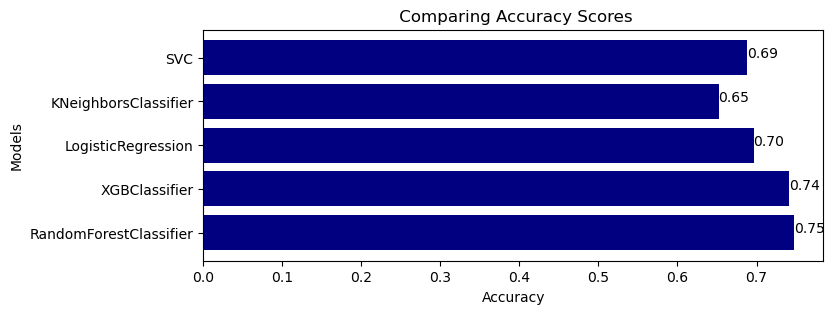

In [15]:
X = prepare_X(df_scaled.drop(["LOS", "LOS_days"], axis=1))
y = prepare_y(pd.DataFrame(df_scaled["LOS"]))

X, y = upsampling_smote(X, y)


different_models(models, X, y)

LogisticRegression, KNN Classifier and SVC got better results with data scaled, as expected, since they are sensitive to the scale of the input features.  Some models benefit from scaling features, otherwise certain features with larger scales might dominate the distance calculation, leading to biased results.

Tree-based algorithms like RF and XGB got similar metric scores (tree-based algorithms do not rely on distance metrics) and are still the ones with the best accuracy scores.


### Transforming Numericals


Some of the continuous numerical variables are not symmetrically distributed therefore I am going to apply a transformation method to try and remove the skewness of some of my variables and try to improve models performance. 

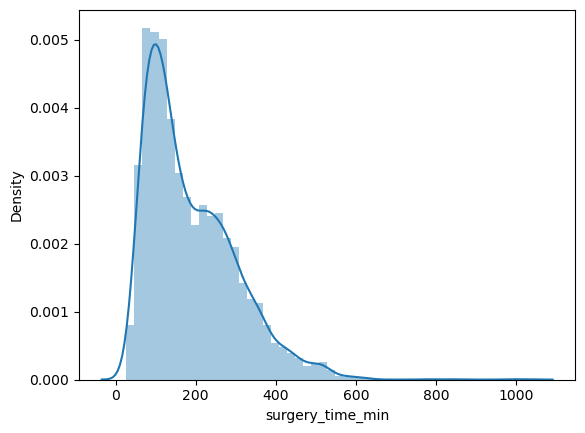

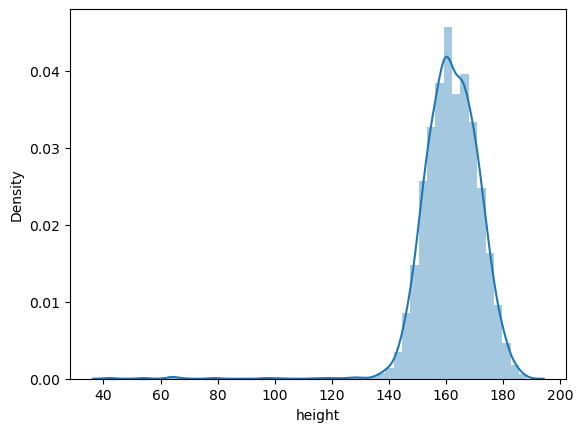

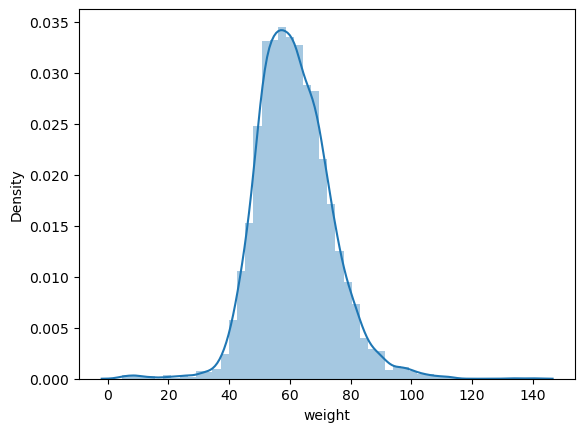

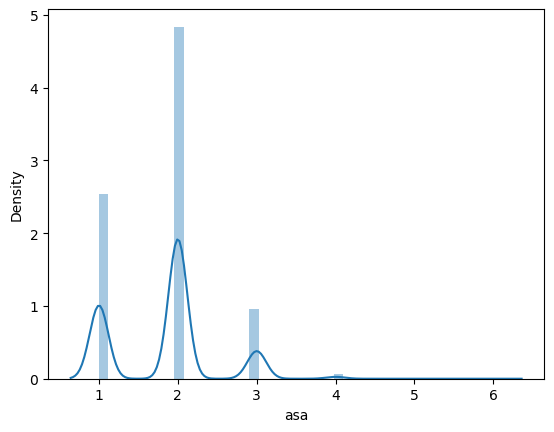

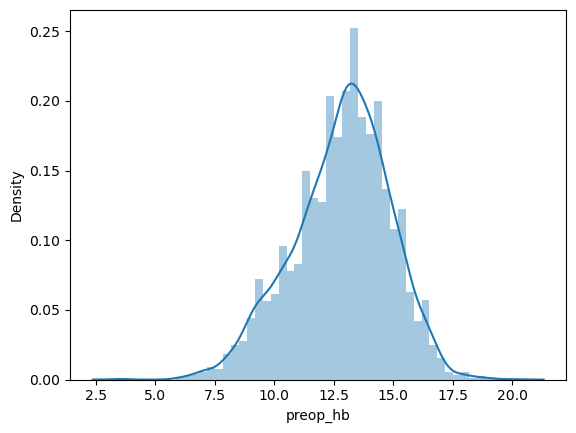

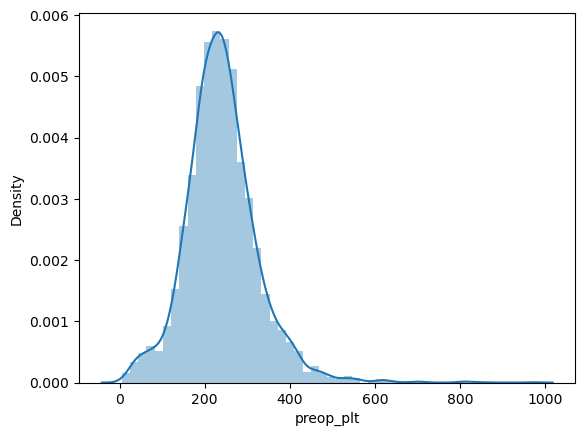

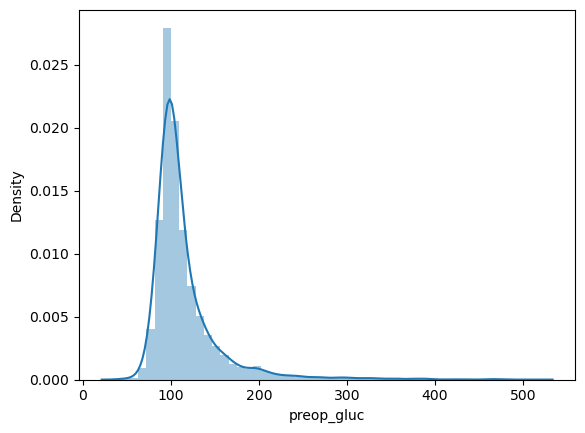

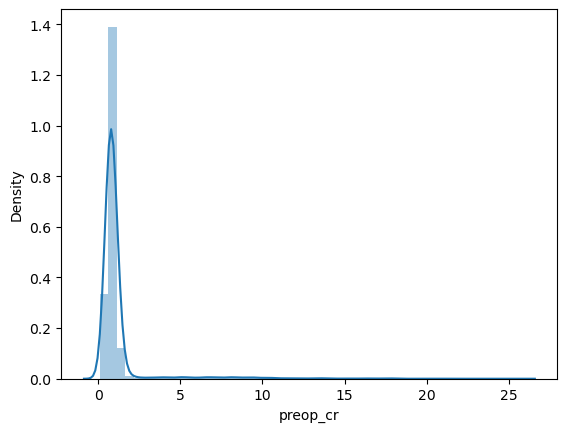

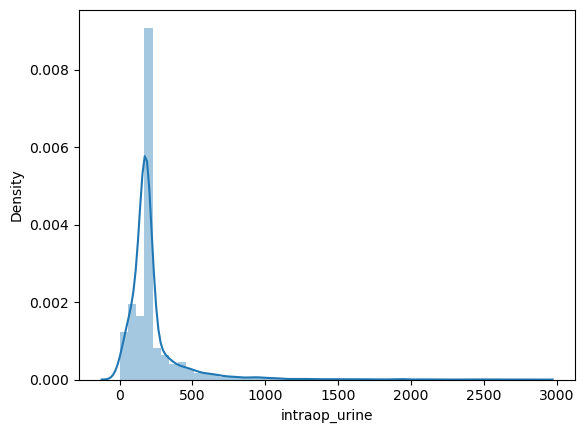

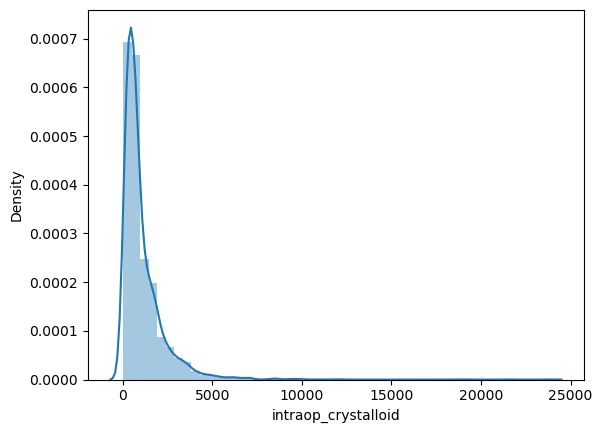

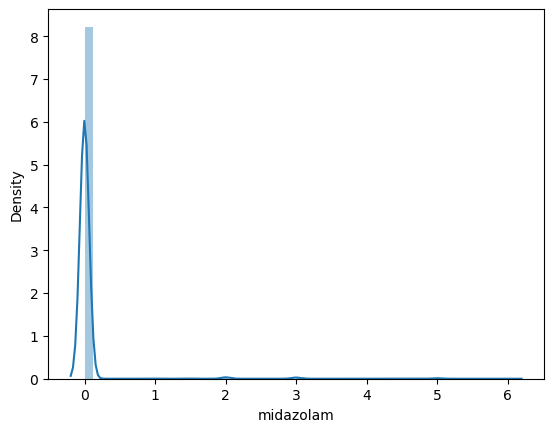

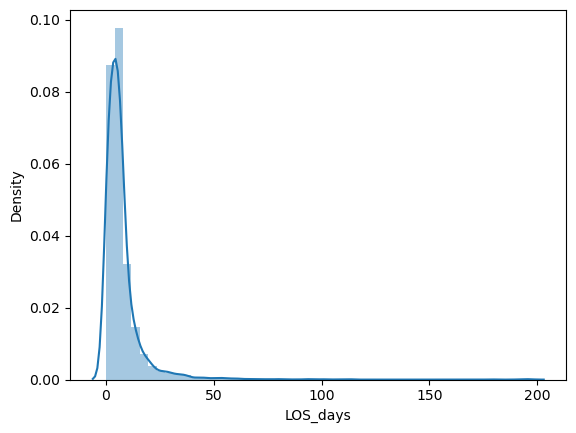

In [16]:
continuous = numerical.select_dtypes(float)

for col in continuous.columns:
    sns.distplot(continuous[col])
    plt.show()

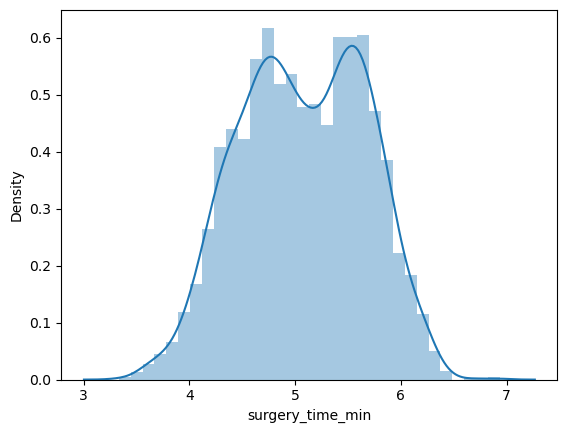

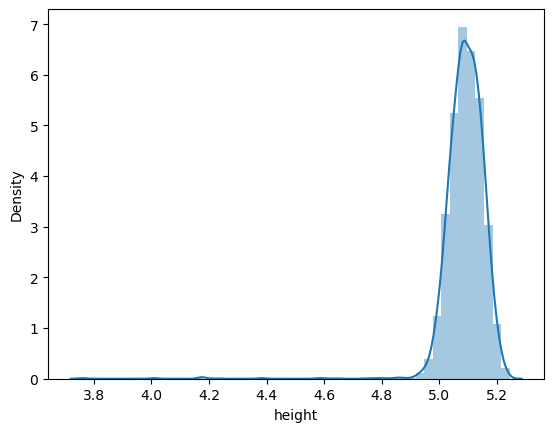

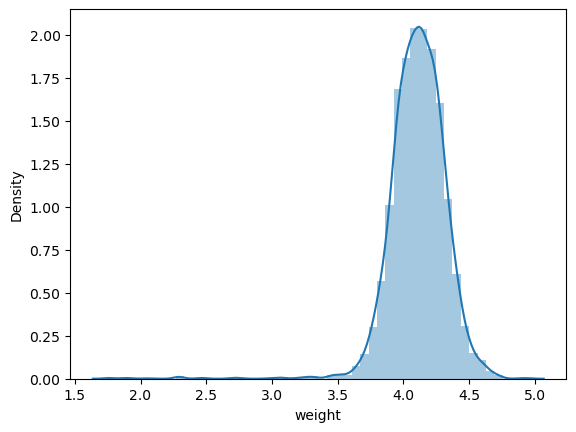

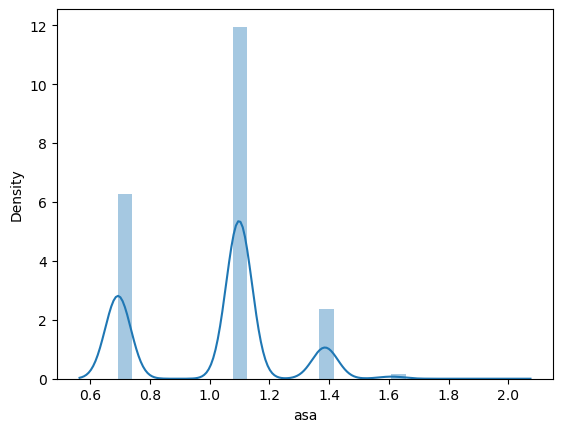

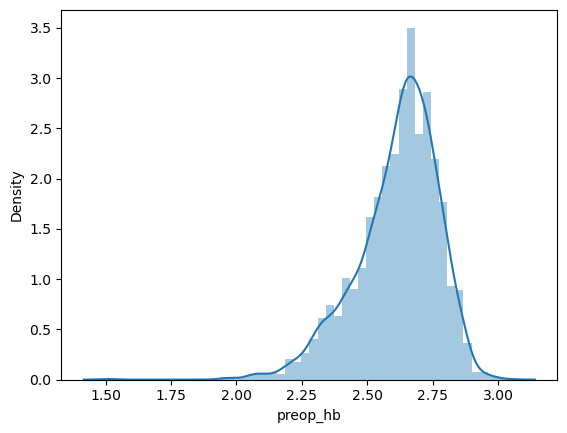

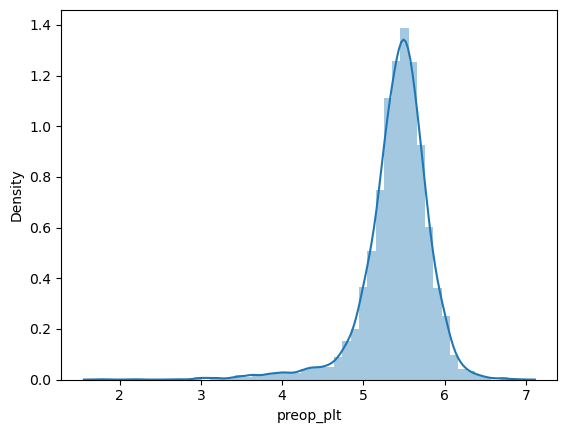

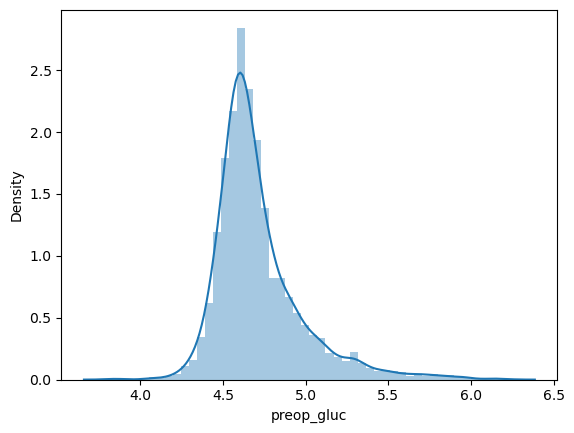

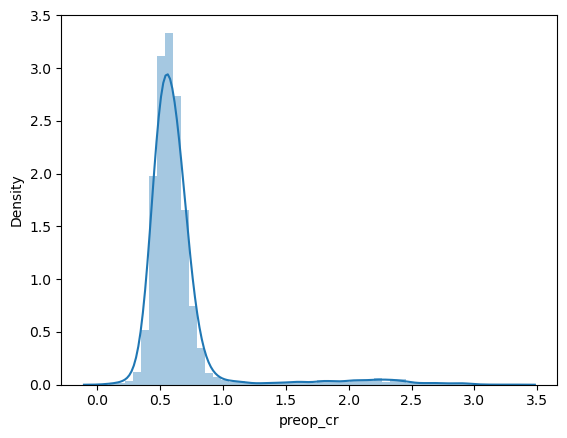

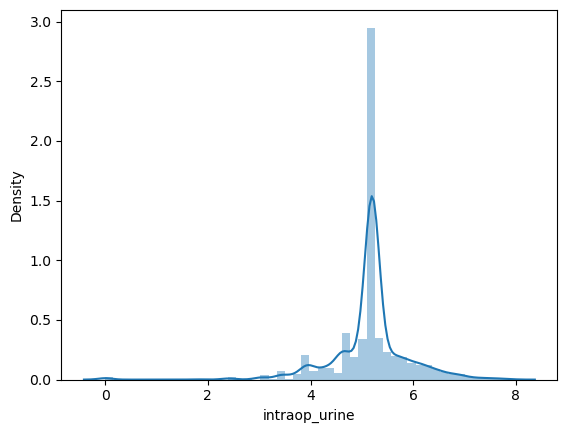

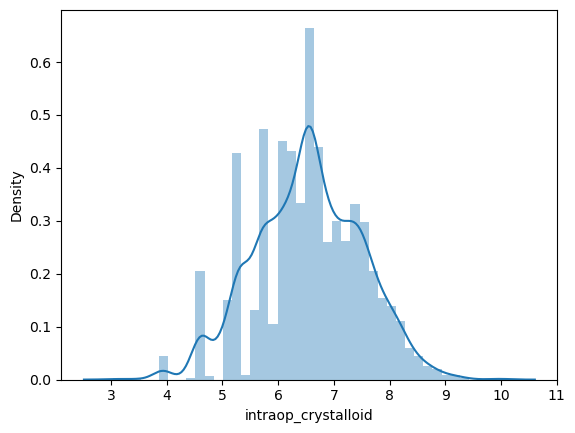

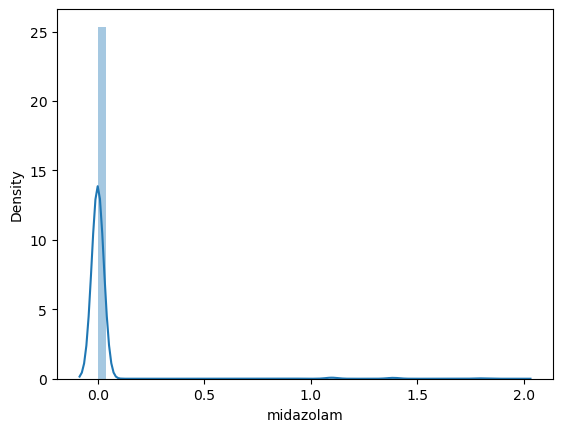

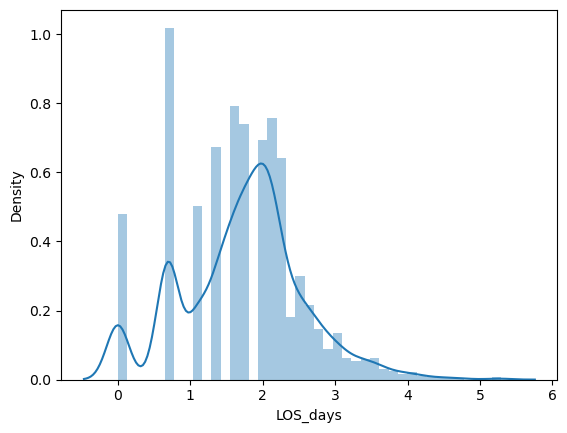

In [17]:
log_transf = np.log(continuous+1)

for col in log_transf.columns:
    sns.distplot(log_transf[col])
    plt.show()

Applying Log transformation did not change much skeweness of continous numerical variables, therefore model performance is unlikely to improve with these "transformed" data.

### Outliers

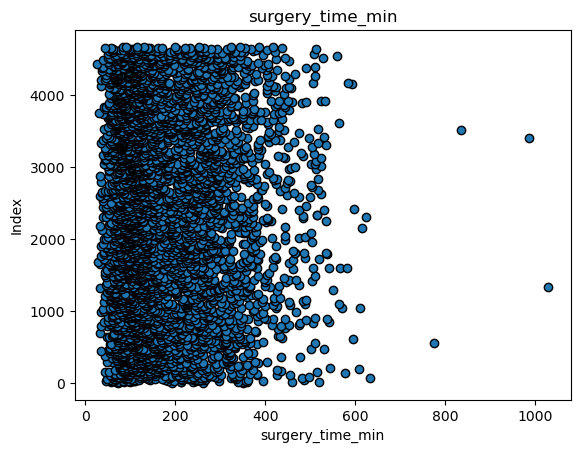

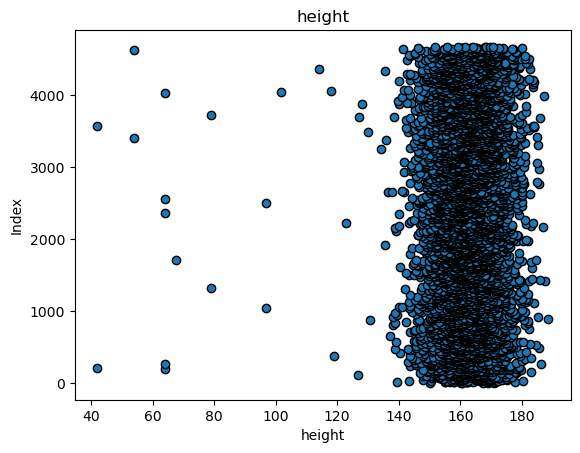

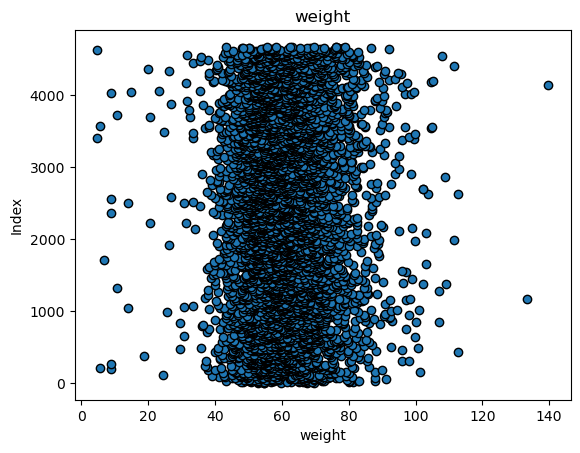

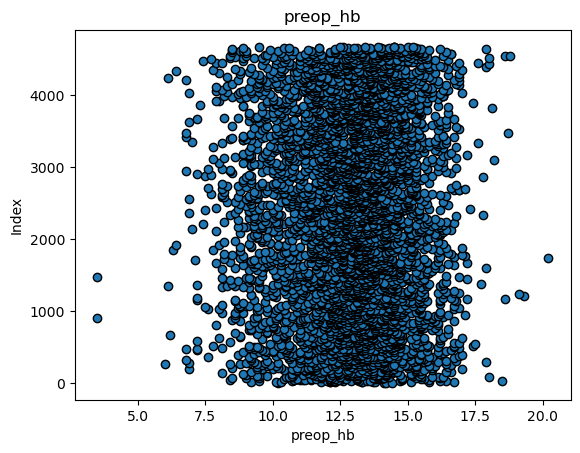

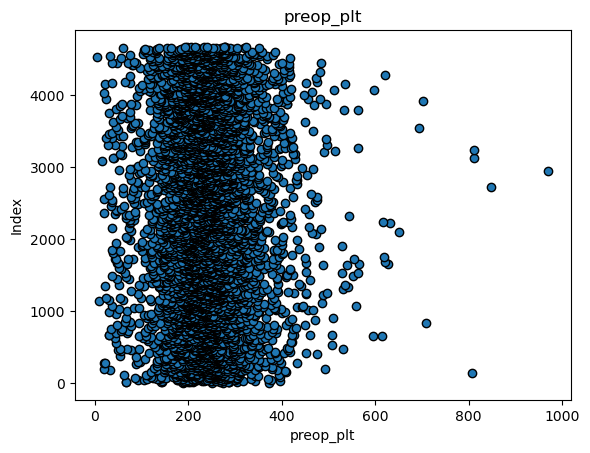

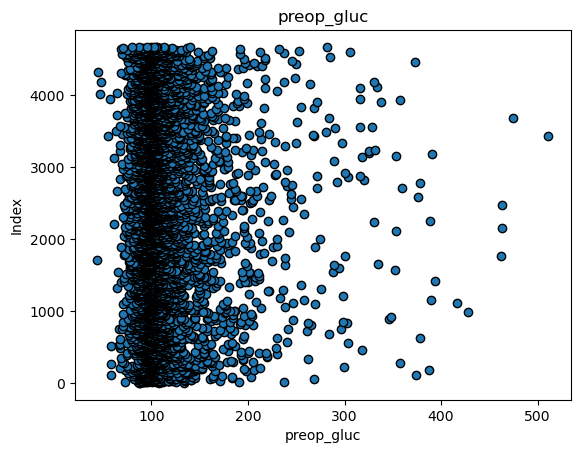

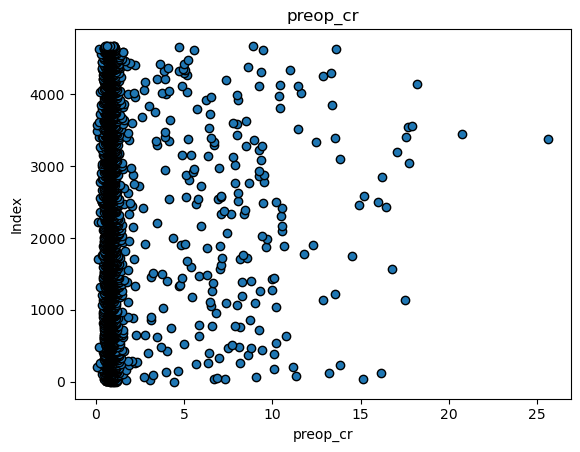

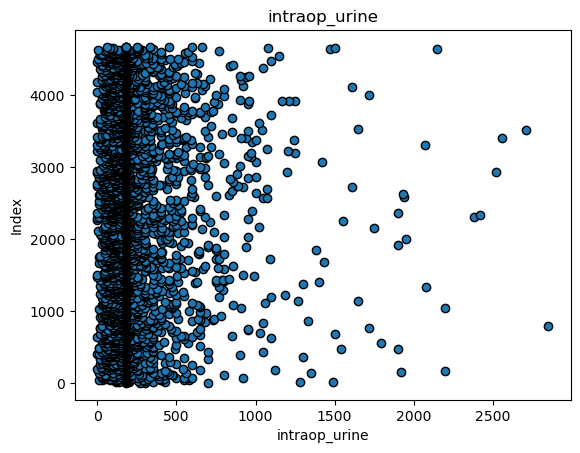

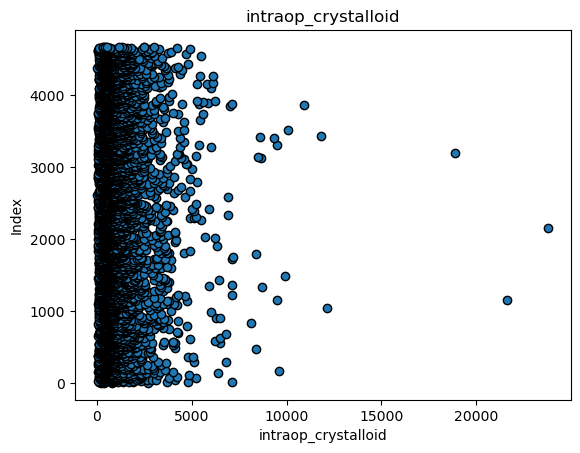

In [18]:
# Analyse presence of Outliers with scatterplot

cols_num=["surgery_time_min", "height", "weight", "preop_hb", "preop_plt", "preop_gluc", "preop_cr", "intraop_urine", "intraop_crystalloid"]

for col in cols_num:
    plt.scatter(df2[col], range(len(df2[col])), edgecolor='black')
    plt.xlabel(col)
    plt.ylabel('Index')
    plt.title(col)
    plt.show()

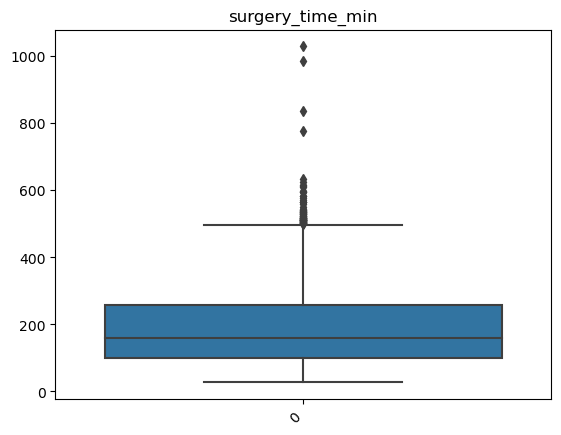

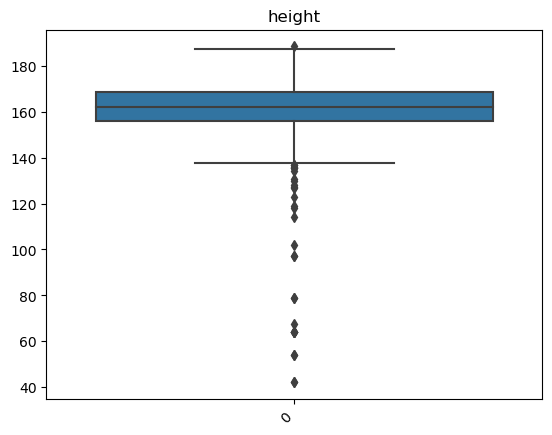

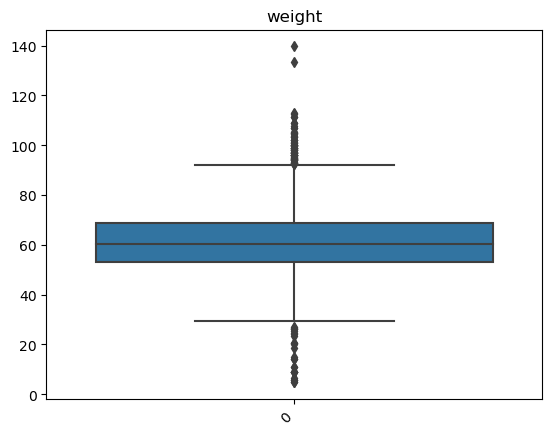

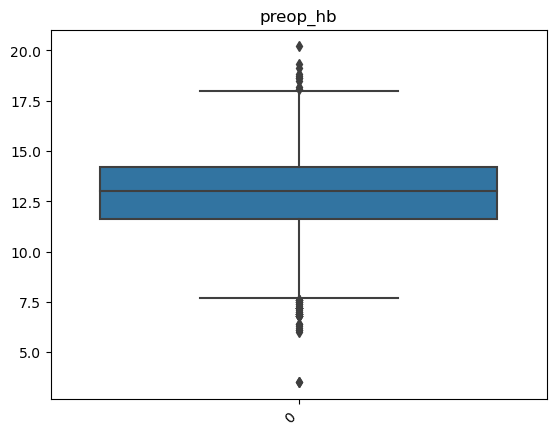

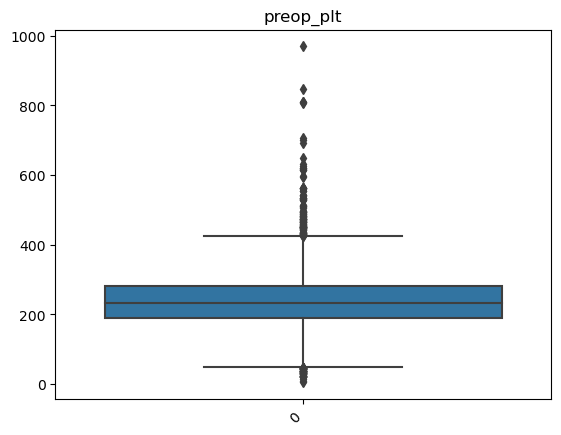

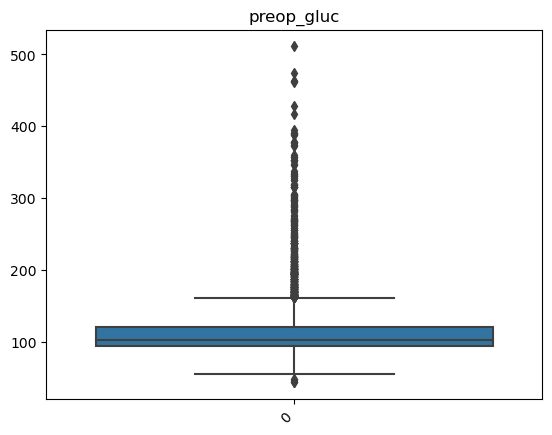

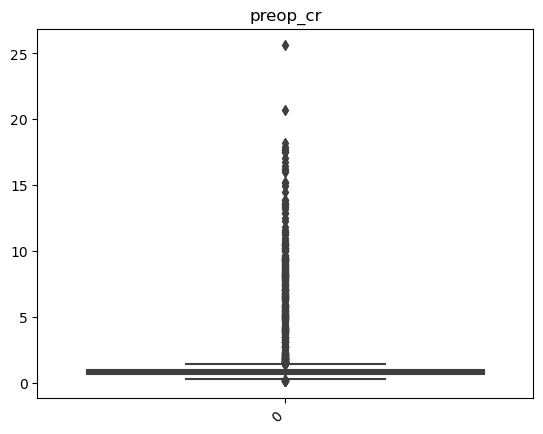

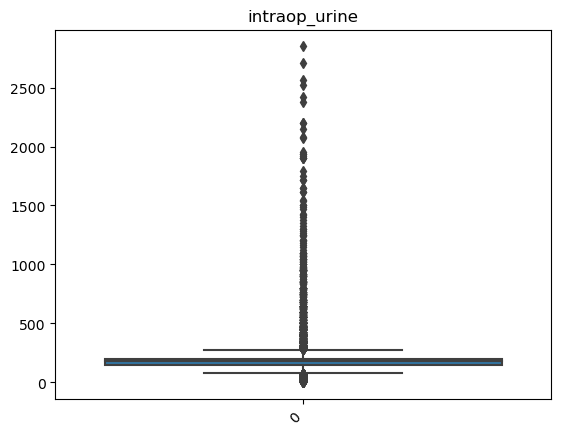

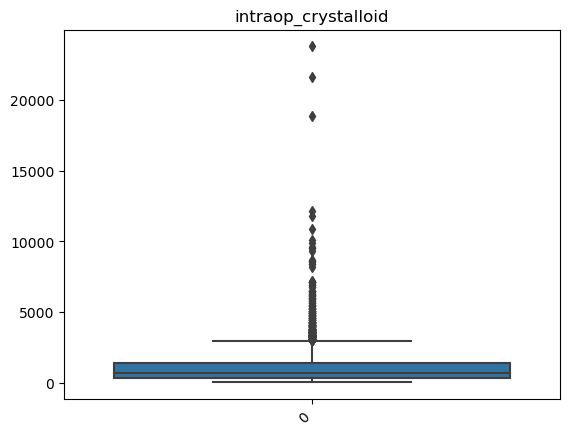

In [19]:
# Let's check the presence of Outliers with boxplot

for columns in cols_num:
    fig, ax = plt.subplots()
    sns.boxplot(data=df2[columns])
    plt.xticks(rotation=45, ha='right')
    ax.set_title(columns)
    plt.show()

- "height", "weight", "preop_hb", "preop_gluc": I am not going to remove any outliers because these extreme data points seem valid entries to me (ex: obese patients / children, diabetic patients)
- "preop_plt" (preop platelet blood result): The normal number of platelets in the blood is between 150 and 400 platelets per microliter (mcL), however there is some clinical conditions that can bring platelet count much higher, therefore these extreme values seem valid to me.
- "preop_cr": creatinine, a normal range is between 0.7 to 1.3 mg/dL, therefore the extreme data points visualized don't seem genuine to me: remove.
- "intraop_crystalloid": 20 Liters of fluids seem not real to me, maybe an entry error: remove

In [20]:
# Funtion to remove outliers in specific columns

cols_remove_outliers = ['preop_cr', 'intraop_crystalloid']

def remove_outliers(df, threshold=1.5, in_columns=None, skip_columns=[]):
    for column in in_columns:
        if column not in skip_columns:
            print(column)
            q3 = np.percentile(df[column], 75)
            q1 = np.percentile(df[column], 25)
            iqr = q3 - q1
            upper_limit = q3 + threshold * iqr
            lower_limit = q1 - threshold * iqr
            df = df[(df[column] > lower_limit) & (df[column] < upper_limit)]
    return df

In [21]:
df_outliers = remove_outliers(df2, threshold=1.5, in_columns=cols_remove_outliers)

preop_cr
intraop_crystalloid


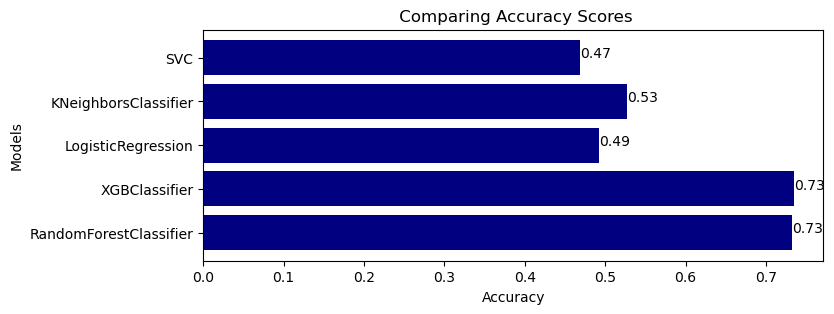

In [22]:
X = prepare_X(df_outliers.drop(["LOS", "LOS_days"], axis=1))
y = prepare_y(pd.DataFrame(df_outliers["LOS"]))

X, y = upsampling_smote(X, y)

different_models(models, X, y)

#### Removing outliers did not change drastically the metrics including  Random Forest and XGB Classifier. Both of them are robust to outliers, therefore removing them don't affect much the performance of these 2 models.

## Feature Selection

Selection of the most relevant features to see if models performance improves!

####  Recursive Feature Elimination (RFE) method

In [23]:
numerical = prepare_X(numerical.drop(["LOS_days"], axis=1))
y = prepare_y(pd.DataFrame(df2["LOS"]))

numerical, y = upsampling_smote(numerical, y)

In [24]:
estimator = RandomForestClassifier()
rfe = RFE(estimator=estimator, n_features_to_select=23, step=1, verbose=False)
rfe.fit(numerical, y)

df_rfe = pd.DataFrame(data = rfe.ranking_, columns=['Rank'])
df_rfe['Column_name'] = numerical.columns
df_rfe

,Rank,Column_name
0,1,surgery_time_min
1,1,icu_days
2,1,height
3,1,weight
4,1,asa
5,1,emergency_op
6,1,preop_htn
7,1,preop_dm
8,1,preop_hb
9,1,preop_plt


All the numerical columns are ranked 1, meaning RFE algorithm considers all these features to be the most important ones for predicting target "LOS"!! Therefore I shouldn't remove any column according to this result.

#### SelectKBest Method

Selecting the top independent features (k) based on their statistical significance with target "LOS".

In [25]:
X = prepare_X(df2.drop(["LOS", "LOS_days"], axis=1))
y = prepare_y(pd.DataFrame(df2["LOS"]))

X, y = upsampling_smote(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [26]:
model = SelectKBest(chi2, k=20).fit(X, y)  # 20 independent features with highest chi-squared statistics are selected.
scores_df=pd.DataFrame(data = model.scores_, columns = ['score'])
scores_df['Features'] = X.columns   #getting column names
scores_df = scores_df.sort_values(by='score', ascending=False)  #higher the score the stronger is the association with target "LOS".
scores_df.head(20)

,score,Features
14,524364.921168,intraop_crystalloid
23,282641.310329,calcium chloride
15,67913.221623,intraop_colloid
21,65700.283601,phenylephrine
22,62467.556763,Epinephrine
0,37351.473445,surgery_time_min
12,31098.892847,intraop_urine
20,2895.645375,ephedrine
16,2391.802506,propofol
1,2294.142438,icu_days


In [27]:
top_20 = scores_df.head(20)['Features'].tolist()

# Creating a new dataframe with only the top 20 features from the original dataframe X.
X = X[top_20].copy()
# Now, new_df will contain only the 20 selected features.

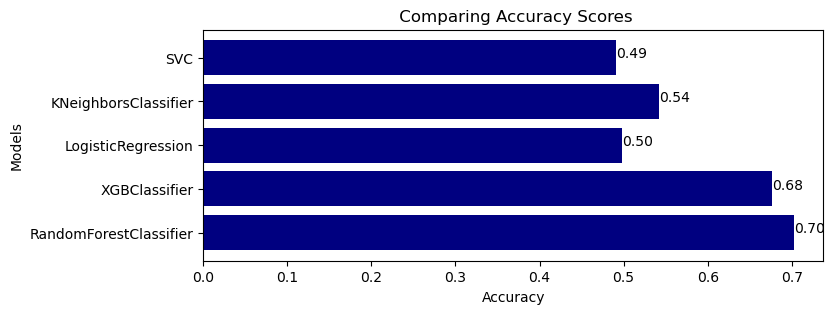

In [28]:
different_models(models, X, y)

All accuracy scores got worst when features with low association with target were removed, perhaps because these features were actually valuable when combined with other features for model performance?

#### Feature Importance built-in the Random Forest algorithm

Let's analyse which features are the most important ones to build the Random Forest Model, which is the one with the highest score.
In Random Forests these importances are calculated based on how much each feature reduces the impurity in the tree (Gini impurity metric). Higher values indicate greater importance, while lower values indicate less importance.

<BarContainer object of 20 artists>

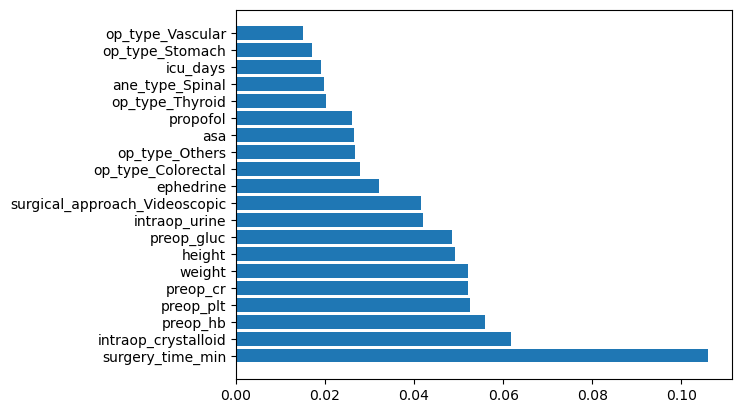

In [29]:
X = prepare_X(df2.drop(["LOS", "LOS_days"], axis=1))
y = prepare_y(pd.DataFrame(df2["LOS"]))

X, y = upsampling_smote(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

features = X_train.columns
features = list(features)

model=RandomForestClassifier()
model.fit(X_train, y_train)   #training the model

df_feat_import = pd.DataFrame(list(zip(features, model.feature_importances_)))   #converting df_feat_import dataframe
df_feat_import.columns = ['columns_name', 'score_feature_importance']
top20=df_feat_import.sort_values(by=['score_feature_importance'], ascending = False).head(20)

plt.barh(top20.columns_name, top20.score_feature_importance)

Ok, let's train the models with these 20 most important features!
Removing less important features can help reduce overfitting and enhance the model's performance.

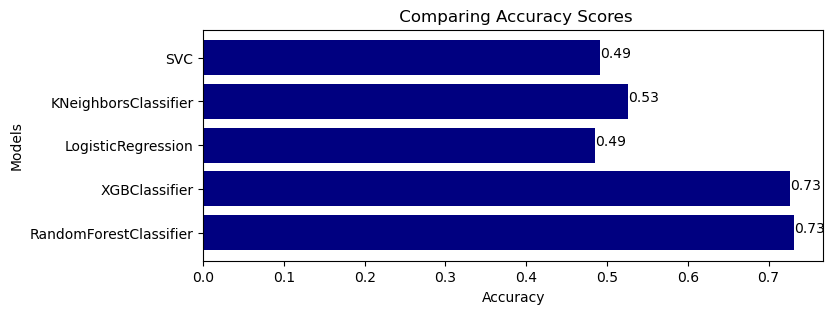

In [31]:
df2_top20= df2[['surgery_time_min', 'intraop_crystalloid', 'preop_hb', 'weight',
       'preop_cr', 'preop_plt', 'height', 'preop_gluc', 'intraop_urine',
       'surgical_approach', 'ephedrine', 'op_type',
       'asa', 'propofol', 'ane_type', 'icu_days']]

X = prepare_X(df2_top20)
y = y.iloc[X.index]
y = prepare_y(pd.DataFrame(df2["LOS"]))
X, y = upsampling_smote(X, y)

different_models(models, X, y)

All the scores are approximately the same.

So far none of the strategies I used improved models performance except for upsampling the imbalance target with SMOTE. **Random Forest Classifier** is still the best model so far in predicting "LOS" target, let's see if we can improve the performance of this model with Hyperparameter Tuning.

### Next: Script "03_Random_Forest_Classifier_Optimization_Evaluation"